# Amount of river Bad input

In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
from Mat2Py import datenum2datetime, datetime2datenum_single

In [2]:
import glob
import scipy.io
import datetime
import numpy as np
#import seaborn as sb
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from NEMO_tools import reporj_NEMOgrid
from dateutil.relativedelta import relativedelta
% matplotlib inline

In [3]:
def seasonal_decomp3d(data, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 1D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data: Time should be the first dim.
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    data2 = np.empty(data.shape)
    for mon in range(12):
        temp_data = np.nanmean(data[mon:len(data):12, :, :], 0)
        if method == 0:
            data2[mon:len(data):12, :, :] = data[mon:len(data):12, :, :]-temp_data
    return data2

In [4]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

In [5]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

In [6]:
MAT = scipy.io.loadmat('../../_data/Exchange/Ba_ANHA4_SRC.mat')
Ba_ANHA4 = MAT['Ba_ANHA4'][:]
Ba_ANHA4 = np.transpose(Ba_ANHA4, [0, 2, 1])

In [27]:
rf_name = sorted(glob.glob('/ocean/yingkai/Repository/CCAR Modeling Team/analysis/Yingkai (Kyle) Sha/_data/NEMO/ANHA4/runoff/*.nc')[2:])
rf_name = rf_name[44:-1]
NUM = len(rf_name)

In [28]:
rf_name

['/ocean/yingkai/Repository/CCAR Modeling Team/analysis/Yingkai (Kyle) Sha/_data/NEMO/ANHA4/runoff/ANHA4_runoff_monthly_combined_Dai_Trenberth_Bamber_y2002.nc',
 '/ocean/yingkai/Repository/CCAR Modeling Team/analysis/Yingkai (Kyle) Sha/_data/NEMO/ANHA4/runoff/ANHA4_runoff_monthly_combined_Dai_Trenberth_Bamber_y2003.nc',
 '/ocean/yingkai/Repository/CCAR Modeling Team/analysis/Yingkai (Kyle) Sha/_data/NEMO/ANHA4/runoff/ANHA4_runoff_monthly_combined_Dai_Trenberth_Bamber_y2004.nc',
 '/ocean/yingkai/Repository/CCAR Modeling Team/analysis/Yingkai (Kyle) Sha/_data/NEMO/ANHA4/runoff/ANHA4_runoff_monthly_combined_Dai_Trenberth_Bamber_y2005.nc',
 '/ocean/yingkai/Repository/CCAR Modeling Team/analysis/Yingkai (Kyle) Sha/_data/NEMO/ANHA4/runoff/ANHA4_runoff_monthly_combined_Dai_Trenberth_Bamber_y2006.nc',
 '/ocean/yingkai/Repository/CCAR Modeling Team/analysis/Yingkai (Kyle) Sha/_data/NEMO/ANHA4/runoff/ANHA4_runoff_monthly_combined_Dai_Trenberth_Bamber_y2007.nc',
 '/ocean/yingkai/Repository/CCAR M

$$
\mathrm{Dissolved\ Barium\ river\ input\ (mol/s)} = \frac{1}{\rho_0}\mathrm{runoff}\Delta x\Delta y\cdot Ba_d\cdot 10^{-6}
$$
$$
\mathrm{Dissolved\ Barium\ residence\ time\ (s)} = \frac{Ba_d(d>50m)}{\mathrm{Dissolved\ Barium\ river\ input}+\mathrm{^*Pacific\ \&\ Atlantic\ input}}
$$

In [29]:
Ba_input = np.zeros([144, 800, 544])
rf_input = np.zeros([144, 800, 544])
for year in range(NUM):
    #print(year)
    nc_obj = nc.Dataset(rf_name[year])
    temp_rf = nc_obj.variables['runoff'][:]*e1t[0, :, :]*e2t[0, :, :]*1e-3   # kg/m2/s --> m3/s
    temp_rf[temp_rf==0]=np.nan
    for mon in range(12):
        #print(mon)
        Ba_input[12*year+mon, :, :] = temp_rf[mon, :, :]*Ba_ANHA4[mon, :, :]*1e-6 # mol/s
        rf_input[12*year+mon, :, :] = temp_rf[mon, :, :] # m3/s

In [30]:
rf_map=glob.glob('../../_data/Samples/STN-30p/runoff_id_modified.mat')
rf_obj=scipy.io.loadmat(rf_map[0])
rf_id=rf_obj['rf_id']
rf_lon=rf_obj['lon']
rf_lat=rf_obj['lat']
rf_id_interp=Nts.reporj_NEMOgrid(rf_lon, rf_lat, rf_id, nav_lon, nav_lat, method='nearest')

In [31]:
Ba_total    = np.nansum(np.nansum(Ba_input[:, :, :],  1), 1)
Ba_Beaufort = np.nansum(Ba_input[:, rf_id_interp==5],  1)
Ba_ESib     = np.nansum(Ba_input[:, rf_id_interp==8],  1)
Ba_Kara     = np.nansum(Ba_input[:, rf_id_interp==12], 1)
Ba_Laptev   = np.nansum(Ba_input[:, rf_id_interp==13], 1)

#rf_total    = np.nansum(np.nansum(rf_input[:, :, :],  1), 1)
#rf_Beaufort = np.nansum(rf_input[:, rf_id_interp==5],  1)
#rf_ESib     = np.nansum(rf_input[:, rf_id_interp==8],  1)
#rf_Kara     = np.nansum(rf_input[:, rf_id_interp==12], 1)
#rf_Laptev   = np.nansum(rf_input[:, rf_id_interp==13], 1)

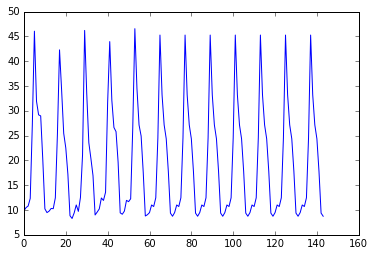

In [32]:
plt.plot(Ba_total)

In [34]:
Ba_total[-48:]

array([  9.47447911,  11.01090681,  10.70238888,  12.46291512,
        24.54477922,  45.27241911,  33.22768603,  27.16314233,
        24.34489587,  17.77353673,   9.37520582,   8.74252496,
         9.47447911,  11.01090681,  10.70238888,  12.46291512,
        24.54477922,  45.27241911,  33.22768603,  27.16314233,
        24.34489587,  17.77353673,   9.37520582,   8.74252496,
         9.47447911,  11.01090681,  10.70238888,  12.46291512,
        24.54477922,  45.27241911,  33.22768603,  27.16314233,
        24.34489587,  17.77353673,   9.37520582,   8.74252496,
         9.47447911,  11.01090681,  10.70238888,  12.46291512,
        24.54477922,  45.27241911,  33.22768603,  27.16314233,
        24.34489587,  17.77353673,   9.37520582,   8.74252496])

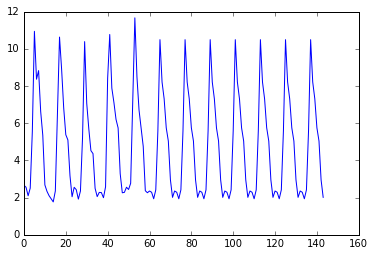

In [13]:
plt.plot(Ba_Beaufort)

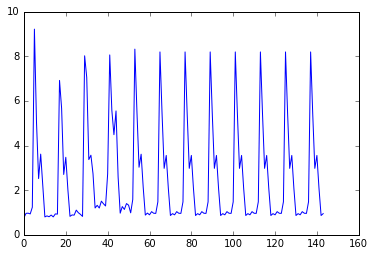

In [14]:
plt.plot(Ba_Laptev)

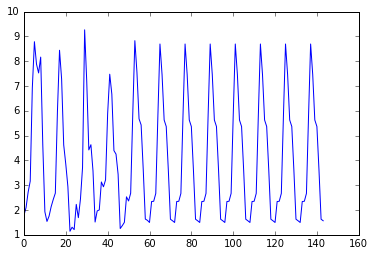

In [15]:
plt.plot(Ba_Kara)

In [16]:
MAT = scipy.io.loadmat('../../_data/Exchange/Ba_flux_param.mat')
Ba_fluxFS_s = -1*MAT['Ba_fluxFS_s']
Ba_fluxBB_s = -1*MAT['Ba_fluxBB_s']

In [17]:
Ba_fluxFS_s[Ba_fluxFS_s<=0]=np.nan
Ba_fluxBB_s[Ba_fluxBB_s<=0]=np.nan
BFS = np.nansum(np.nansum(Ba_fluxFS_s, 1), 1)
BBS = np.nansum(np.nansum(Ba_fluxBB_s, 1), 1)

/home/yingkai/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/home/yingkai/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from IPython.kernel.zmq import kernelapp as app


In [18]:
Ba_Beaufort_year = np.mean(np.reshape(Ba_Beaufort, [12, 12]), 1)
Ba_ESib_year = np.mean(np.reshape(Ba_ESib, [12, 12]), 1)
Ba_Kara_year = np.mean(np.reshape(Ba_Kara, [12, 12]), 1)
Ba_Laptev_year = np.mean(np.reshape(Ba_Laptev, [12, 12]), 1)

BFS_year = np.mean(np.reshape(BFS, [12, 12]), 1)
BBS_year = np.mean(np.reshape(BBS, [12, 12]), 1)

In [35]:
from scipy.stats.stats import pearsonr

In [121]:
pearsonr(BFS[:-7], Ba_Laptev[7:])

(0.59766989740797993, 1.2550854272305923e-14)

In [88]:
pearsonr(BFS[:-6], Ba_Beaufort[6:])

(0.62142504359121298, 5.3823096201498573e-16)

In [103]:
pearsonr(BFS[:-6], Ba_Kara[6:])

(0.62401259927712127, 2.9257518410582423e-16)

In [98]:
pearsonr(BBS[:-6], Ba_Beaufort[6:])

(0.24575165727480344, 0.0035447971917616141)

In [102]:
pearsonr(BBS[:-6], Ba_Kara[6:])

(0.32538479282975408, 9.8542407595720961e-05)

In [106]:
pearsonr(BBS[6:], Ba_Laptev[:-6])

(0.28938153053045157, 0.00057636147271427967)

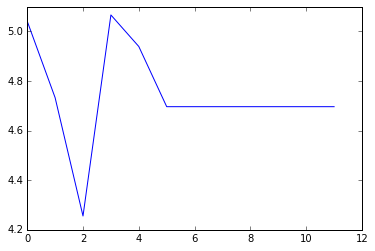

In [109]:
plt.plot()